In [1]:
import os
import sys

# Add the project's root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import random

import numpy as np
import torch

from GP_comp.GP import generate_grids
from SGLD_v7 import SgldBayesianRegression as V7, select_significant_voxels
from models.stgp_neural_network import STGPNeuralNetwork
from simulate_single_modality import simulate_data
from utils import generate_linear_data, plot_values, plot_mse, plot_sigma_squared
# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [2]:
in_feature = 5

In [3]:
# Step 2: Generate synthetic data
# simulate a batch of images
dim = in_feature           # e.g. 16 for a 16×16 grid → V=256
r2 = 0.8                  # signal-to-noise ratio
n = 20000                  # number of images/samples
v_list, true_beta, img, Y, true_sigma2 = simulate_data(
    n=n, r2=r2, dim=dim, random_seed=42)
# torch tensors
X = torch.from_numpy(img).float().to('cpu')    # shape [n, V]
y = torch.from_numpy(Y).float().to('cpu')      # shape [n]
grids = v_list                                  # shape [V, 2]
# pick one of your simulated images
idx = 0
inputs = X[idx : idx+1]       # shape [1, V]
expected_y = Y[idx]
print(f"Simulated {n} images of {dim}×{dim} = {img.shape[1]} pixels")

Simulated 20000 images of 5×5 = 25 pixels


In [4]:
# Step 4: Build model
model = STGPNeuralNetwork(
    in_feature=in_feature,
    grids=grids,
    fully_connected_layers =[3,1],
    dimensions=2
)

In [5]:
# Step 5: Train with SGLD
trainer = V7(
    step_size=0.00002,
    num_epochs=300,  # fix this back to 300 later
    burn_in_epochs=0,
    batch_size=2000,
    model=model
)

In [6]:
indices = torch.randperm(X.size(0))
X, y = X[indices], y[indices]
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train with MSE tracking every 10 epochs
trainer.train(X_train, y_train)

print(f"Y(predicted)={trainer.predict(inputs, gamma=0.05)} Y(expected)={expected_y}")

Epoch 1/300
time elapsed 0.000997304916381836 seconds
Epoch 101/300
time elapsed 37.44647431373596 seconds
Epoch 201/300
time elapsed 71.97121858596802 seconds
Threshold δ=0.997, selecting r=25 voxels at FDR=0.05
predict (sample_avg)::variance_prediction=[[0.39290673]]
Y(predicted)=tensor([[0.0916]]) Y(expected)=9.600000097464498


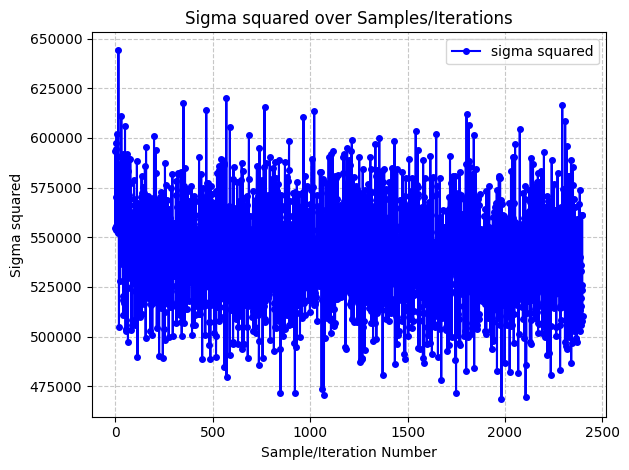

In [7]:
plot_sigma_squared(trainer)

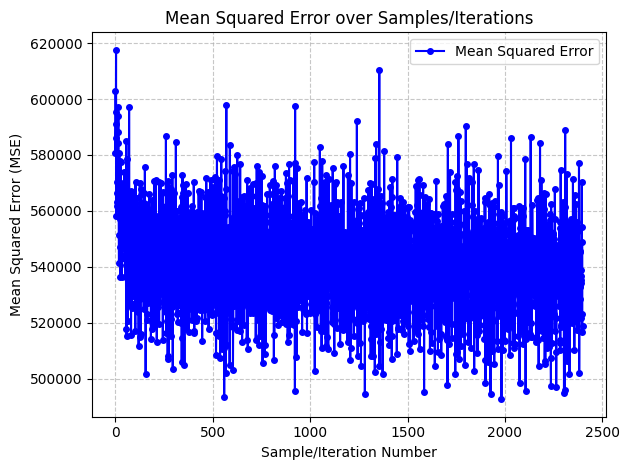

In [8]:
plot_mse(trainer)

In [9]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 82


In [10]:
print(model.input_layer.beta.requires_grad)

True


In [11]:
[p for p in model.parameters()]

[Parameter containing:
 tensor([[-0.0998,  0.4192, -0.2986, -0.4548,  0.0333, -0.1503, -0.3180, -0.0206,
           0.0145, -0.2650, -0.0863,  0.2153,  0.0816, -0.6760, -0.4422, -0.3408,
           0.1096, -0.1585,  0.0495, -0.2168, -0.0367,  0.2367,  0.2632,  0.1729,
           0.2857],
         [-0.2033, -0.0904, -0.2652,  0.3220,  0.0673, -0.0831, -0.0619,  0.0579,
           0.1918,  0.0155,  0.2912,  0.0380,  0.2730, -0.1706, -0.1162,  0.2863,
          -0.2760,  0.4150, -0.3904,  0.3263,  0.4133, -0.6506, -0.0496,  0.4956,
          -0.0242],
         [ 0.4388, -0.2417, -0.3927, -0.4199,  0.1520,  0.1752, -0.2004, -0.5609,
          -0.3643, -0.1293, -0.2414,  0.0467, -0.2217,  0.1242,  0.2957, -0.2702,
           0.3389,  0.1368,  0.3294, -0.3601,  0.0370,  0.1026, -0.0693,  0.1679,
           0.1150]], requires_grad=True),
 Parameter containing:
 tensor([-0.4492,  0.1564, -0.0431], requires_grad=True),
 Parameter containing:
 tensor([[ 0.9678,  0.1337, -0.2987]], requires_grad=

In [12]:
print(trainer.samples['nu'][:10])


[tensor([0.0119]), tensor([0.0129]), tensor([0.0131]), tensor([0.0144]), tensor([0.0124]), tensor([0.0133]), tensor([0.0132]), tensor([0.0139]), tensor([0.0122]), tensor([0.0135])]


In [13]:
print(trainer.samples['sigma_lambda_squared'][:10])

[tensor([0.0142]), tensor([0.0167]), tensor([0.0171]), tensor([0.0206]), tensor([0.0153]), tensor([0.0178]), tensor([0.0174]), tensor([0.0192]), tensor([0.0148]), tensor([0.0181])]


In [14]:
beta_samples = []
param_shape = model.input_layer.beta.shape
for flat_params in trainer.samples['params'][:10]:
    # find and reconstruct only the beta parameter
    idx = 0
    for p in model.parameters():
        numel = p.numel()
        if p is model.input_layer.beta:
            chunk = flat_params[idx:idx + numel]
            beta = torch.from_numpy(chunk.reshape(param_shape)).to('cpu')
            # apply the same soft‐threshold you use in train
            thresholded_beta = model.input_layer.soft_threshold(
                beta)  # thresholded_beta.shape() = (amount of units, amount of voxels)
            beta_samples.append(thresholded_beta.detach().cpu().numpy())
            break
        idx += numel
print(beta_samples)

[array([[-4.7500702e-03, -0.0000000e+00, -2.2587557e-01, -2.9833462e-02,
        -0.0000000e+00,  0.0000000e+00, -0.0000000e+00, -5.4648006e-01,
        -3.3211672e-01, -4.2599846e-02, -0.0000000e+00,  2.6712885e-01,
         1.3720170e-01, -1.6559568e-01, -2.5460538e-01, -0.0000000e+00,
         2.4880223e-01,  1.9971785e-01, -7.7071905e-02, -6.3453749e-02,
         1.9831020e-02,  2.2327819e-01,  9.1347083e-02,  0.0000000e+00,
        -0.0000000e+00],
       [ 0.0000000e+00, -9.2370838e-02, -4.0357452e-02,  4.7375042e-02,
        -0.0000000e+00,  0.0000000e+00, -1.5401347e-01, -3.3985369e-02,
         6.1160967e-02, -0.0000000e+00,  8.2860678e-02,  1.1068734e-01,
         1.2167336e-01,  3.9053131e-02, -4.5132041e-02, -7.8173941e-03,
        -2.3421653e-01,  0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
        -2.2323485e-02, -1.9062623e-01,  0.0000000e+00,  1.2873913e-01,
        -0.0000000e+00],
       [ 0.0000000e+00,  1.0294397e-02,  0.0000000e+00, -5.1134592e-03,
        -1.50